# Echo State Network as a tunable frequency generator

This is a simplified implementation of Herbert Jaeger's task of learning a simple non-autonomous system, [a frequency generator controlled by an external signal](http://www.scholarpedia.org/article/Echo_state_network). Plots at the end.

[See the ESN implementation](https://github.com/cknd/pyESN).


In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from pyESN import ESN
from signalgen import *

## Task

The network will learn to generate a wave signal whose frequency is determined by some slowly changing control input.

#### 1) Generate some sample data:


In [2]:
rng = np.random.RandomState(42)

# updown signal
N = 15000 # signal length
n_changepoints = int(N/200)
x_ud = updown_generator(N, n_changepoints, rng)

# sine wave
x_sn = np.vstack((np.sin(np.arange(N)/np.pi/10), np.ones(N))).T
x = np.multiply(x_ud, x_sn)

max_order = 3
antiderivative = True
y = signal1d_derivatives(x[:, 0], max_order, antiderivative)
if antiderivative:
    y[:,-1] = y[:,-1] / 30 + 2 

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = x[:traintest_cutoff], y[:traintest_cutoff]
test_ctrl, test_output  = x[traintest_cutoff:], y[traintest_cutoff:]

#### 2) Instantiate, train & test the network
Parameters are mostly the same as in Herbert Jaeger's original Matlab code. 

In [3]:
n_outputs = max_order + 1 + antiderivative

esn = ESN(n_inputs = 2,
          n_outputs = n_outputs,
          n_reservoir = 200,
          spectral_radius = 0.2,
          sparsity = 0.9,
          noise = 0.001,
          input_shift = [-.5,-.5],
          input_scaling = [2, 2],
          teacher_scaling = .2,
          teacher_shift = 0,
          out_activation = np.tanh,
          inverse_out_activation = np.arctanh,
          random_state = rng,
          silent = False)

pred_train = esn.fit(train_ctrl, train_output)

print("test error:")
pred_test = esn.predict(test_ctrl)
print(np.sqrt(np.mean((pred_test - test_output)**2)))

harvesting states...
fitting...
training error:
0.007681137498373484
test error:
0.41765228644508556


#### 3) Plots
First, a look at the control signal, the target signal and the output of the model both during training and during testing.

Text(0.5, 1.0, 'test (excerpt)')

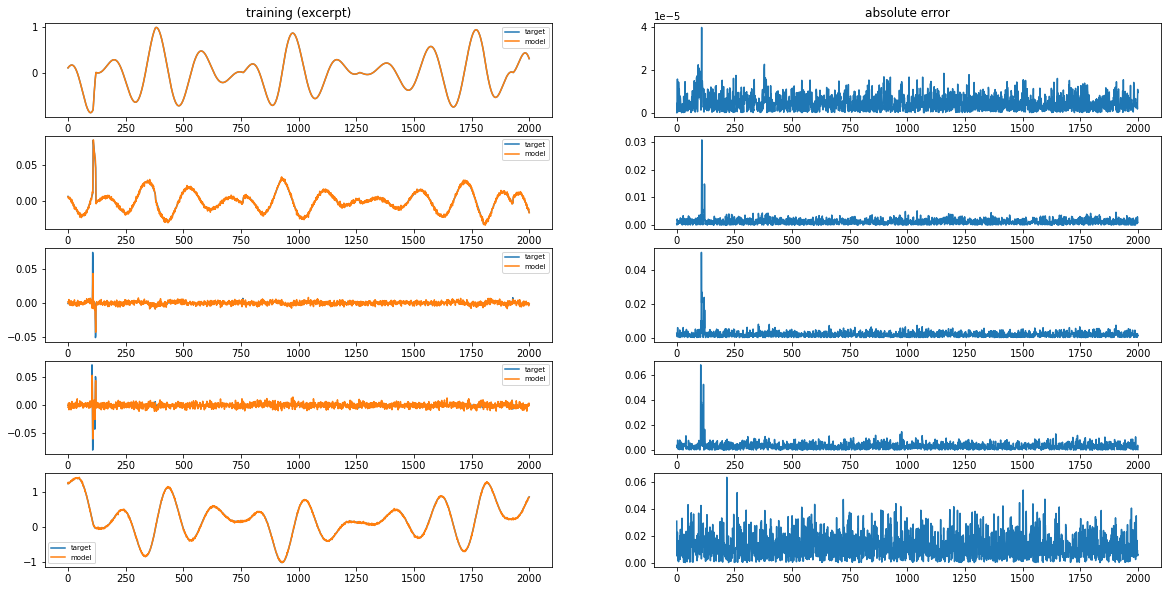

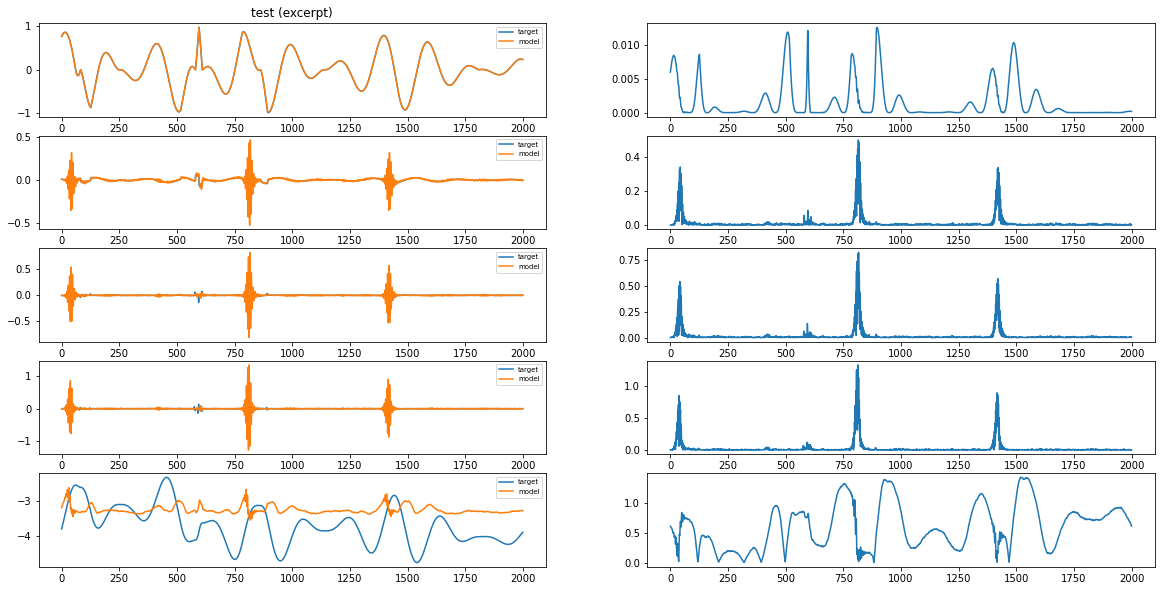

In [4]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
fig, axes = plt.subplots(n_outputs, 2, figsize=(20,10))
for axrow, y, yhat in zip(axes, train_output.T, pred_train.T):
    axrow[0].plot(y[window_tr],label='target')
    axrow[0].plot(yhat[window_tr],label='model')
    axrow[0].legend(fontsize='x-small')
    axrow[1].plot(abs(y[window_tr]-yhat[window_tr]))
axes[0,0].set_title('training (excerpt)')
axes[0,1].set_title('absolute error')

window_test = range(2000)
fig, axes = plt.subplots(n_outputs, 2, figsize=(20,10))
for axrow, y, yhat in zip(axes, test_output.T, pred_test.T):
    axrow[0].plot(y[window_test],label='target')
    axrow[0].plot(yhat[window_test],label='model')
    axrow[0].legend(fontsize='x-small')
    axrow[1].plot(abs(y[window_test]-yhat[window_test]))
axes[0,0].set_title('test (excerpt)')
